# Monte Carlo Simulation

#### By Lukas Schweiger - Montanuniversität Leoben - Department Materials Science

#### Importing required packages

In [1]:
import numpy as np
import random
import pandas as pd
import os  # For folder creation
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from matplotlib import ticker
from scipy import constants
import seaborn as sns
from tqdm import tqdm  # For progress bar
from PIL import Image
from glob import glob

# Defining the inch to cm ratio for plotting 
cm=1/2.54

# Metal Grid

### Overview of the functions

Function to initialize the grid with quadrants (checkerboard-like pattern with 4 fields)

`def initialize_grid(grid_size):`

---

Alternatively we can generate a grid from any binary image derived from a real SEM image

`def initialize_grid_from_image(image_path, grid_size):`

---

Function to perform a shear step (mechanical intermixing) with flow strength weighting

`def shear_step(metal_grid, shear_type="both", strength_A=1, strength_B=0.2, shear_counts=None): Performs the shear steps simulating plastic deformation`

---

Function to calculate local energy around a site (x, y), considering periodic boundary conditions

`def calculate_metal_metal_interaction_energy(x, y, metal_grid, _AA, E_BB; E_AB):`

---

Function to calculate total energy of the grid, considering periodic boundary conditions

`def calculate_total_metal_metal_interaction_energy(metal_grid, _AA, E_BB; E_AB):`

---

Function to perform one Monte Carlo step (diffusion)

`def metal_diffusion_step(metal_grid, kT, E_AA, E_BB; E_AB):`

---

Function to calculate the mixing index of the grid, considering periodic boundary conditions

`def calculate_mixing_index(metal_grid):`

---

Function to sample energy values from a normal distribution

`def sample_energy(E_mean, E_std)`

---

Function to yield the interval for sampling the mixing index and totoal energy, dependent on the total number of Monte Carlo (MC) steps:

`def get_sampling_interval(n_mc_steps):`

---

#### def initialize_grid():

This grid initialization represents a physical system where two types of atoms (A and B) are initially present in separate regions. The system starts in a highly ordered state, with A atoms in the top-left and bottom-right quadrants and B atoms in the top-right and bottom-left quadrants. This segregation can mimic a scenario like phase separation or a structured alloy with two different metal components - but overall this is an EXAMPLARY MODEL MICROSTRUCTURE.
(Was used for first simulation trials)

##### A atoms, e.g., TiVZrNbHf - 0

##### B atoms, e.g., Cu - 1

In [2]:
# Function to initialize the grid with quadrants (checkerboard-like pattern with 4 fields)
def initialize_metal_grid(grid_size):
    """
    This defines a function named initialize_metal_grid().
    The purpose of this function is to initialize a metal grid with a checkerboard-like pattern
    consisting of four quadrants, representing two different types of atoms A (=0) and B (=1).
    A (=0) is the metal with high hydrogen affinity, B (=1) the atom with low hydrogen affinity.
    
    Parameters:
    - grid_size          : int, the size of the desired grid (e.g., 100 for a 100x100 grid).
    
    Returns:
    - metal_grid         : 2D numpy array, where 0 represents one type of atom (A / HEA) and 1 represents another (B / Cu).
    """
    
    # Creates a 2D array of size grid_size x grid_size, filled with zeros.
    metal_grid = np.zeros((grid_size, grid_size), np.int64) # np.int64 is important for the compilation using numba / njit
    
    # This calculates half_size as half of the total grid size (grid_size), using integer division (//).
    half_size = grid_size // 2
    
    # Assigns 0 (representing A atoms) and 1 (representing B atoms) to the top-left quadrant of the grid.
    metal_grid[:half_size, :half_size] = 0  # Top-left quadrant (A atoms)
    metal_grid[:half_size, half_size:] = 1  # Top-right quadrant (B atoms)
    metal_grid[half_size:, :half_size] = 1  # Bottom-left quadrant (B atoms)
    metal_grid[half_size:, half_size:] = 0  # Bottom-right quadrant (A atoms)
    
    return metal_grid

#### Demonstration

In [3]:
grid_size = 4
metal_grid = initialize_metal_grid(grid_size)

metal_grid

array([[0, 0, 1, 1],
       [0, 0, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 0, 0]], dtype=int64)

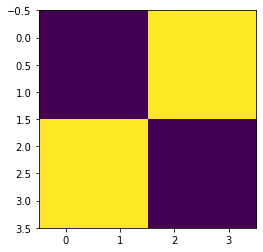

In [4]:
# Plot grid to show that the Numpy Array 
plt.imshow(metal_grid)

---

#### def initialize_grid_from_image():

This grid initialization represents a physical system where two types of atoms (A and B) are initially segregated into separate regions. The system starts in a state that is given by a binary image derived from an SEM image. This can mimic a scenario that is closer to a real starting structure before, e.g., HPT.

Details about the loading and conversion:
https://stackoverflow.com/questions/52307290/what-is-the-difference-between-images-in-p-and-l-mode-in-pil

Details about the image downscaling - In particular the "Antialiasing":
https://github.com/python-pillow/Pillow/issues/6200

In [5]:
# Alternatively we can generate a grid from any binary image derived from a real SEM image
def initialize_grid_from_image(image_path, grid_size):
    """
    Initializes a grid based on a binary input image. 
    Such a binary imput image can be a "thresholded" SEM image of a real microstructure.
    
    Parameters:
    - image_path           : str, path to the binary image file (black-and-white).
    - grid_size            : int, the size of the desired grid (e.g., 100 for a 100x100 grid).
    
    Returns:
    - metal_grid           : 2D numpy array, where 0 represents one type of atom (A / HEA)
                             and 1 represents (B / Cu) another.
    """
    # Load the image in grayscale mode and convert it to a binary (black-and-white) image (this is done by .convert("L"))
    img = Image.open(image_path).convert("L")
    
    # Resize the image to the desired grid size, using antialiasing to improve downscaling
    img_resized = img.resize((grid_size, grid_size), Image.LANCZOS) # PIL.ANTIALIAS was removed in Pillow 10.0.0
    
    # Convert image to binary values (0 or 1) based on a threshold (128 is the midpoint of grayscale)
    metal_grid = np.array(img_resized) > 128
    metal_grid = metal_grid.astype(np.int64)  # Convert to integer (0s and 1s); np.int64 is important for the compilation using numba / njit
    
    return metal_grid

#### Demonstration

In [6]:
grid_size = 100

FILEPATH_STARTING_CONFIGURATION = "Real_starting_conf.png"
metal_grid = initialize_grid_from_image(FILEPATH_STARTING_CONFIGURATION, grid_size)
metal_grid

array([[0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 1]], dtype=int64)

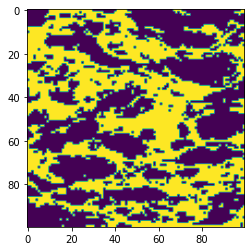

In [7]:
# Plot grid to show that the Numpy Array actually represents the (binary) SEM image.
# Dark color represent 0, i.e., the A atoms.
plt.imshow(metal_grid)

The original "thresholded" SEM image is plotted in the next cell.

It must be noted that in this plot the initial structure becomes inverted when loading in python, i.e., 0 get 1, 1 get 0.

However, in "initialize_grid_from_image" 0 remains 0 and 1 remains 1. 

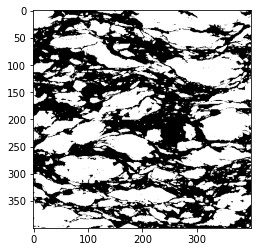

In [8]:
img = Image.open(FILEPATH_STARTING_CONFIGURATION).convert("L")
plt.imshow(img, cmap='Greys')

---
### def shear_step():

#### Physical Interpretation:

This shear step mimics a mechanical force acting on the material, where part of the grid is displaced horizontally or vertically.

- Horizontal shear shifts atoms to the right (above the line) simulating physical displacement in a real material.


- Vertical shear shifts atoms up (right of the line) which also represents mechanical displacement.

It can be set to "horizontal" or "vertical" or "both" if the deformation should be idealized shear or if there should be some other component.
This can simulate mechanical intermixing in alloys or composite materials, where (severe) plastic flow might cause atoms to mix through simple shear displacements.

The probability of a shear step is coupled with the number A and B atoms along the shear plane.

- Many "hard / high strength" atoms / fields result in a lower shear probability.


- Many "soft / low strength" atoms result in an increased shear probability.

This addition can simulate deformation localization that is ofter observed in composite materials with rather large strength differences, i.e. hard-soft composites. The shear probability is implemented using a while loop. The deformation is forced externally and has to be performed in order to conform to a certain strain rate.

---

In [9]:
def shear_step(metal_grid, shear_type, strength_A, strength_B, shear_counts_horizontal, shear_counts_vertical, max_attempts):
    """
    Performs a shear step on a grid with probability weighted by the cumulative strength of atoms along the shear line.
    The lower the total strength, the higher the probability for the shear step to occur.
    
    Parameters:
    - metal_grid                 : 2D numpy array, the grid of atoms.
    - shear_type                 : str, specifies the type of shear to apply:
                                    - 0 for horizontal shear only
                                    - 1 for vertical shear only
                                    - 2 for randomly selecting between horizontal and vertical (default).
    - strength_A                 : float, "flow strength" or "Hardness" of atom type A.
    - strength_B                 : float, "flow strength" of "Hardness" atom type B.
    - shear_counts_horizontal    : np.array, for saving the locations where shear steps were already performed
    - shear_counts_vertical      : np.array, for saving the locations where shear steps were already performed
    - max_attempts               : int, maximum number of iterations until which shear is enforced, avoid while loop for compiling.
    
    Returns:
    - None
    """
    
    grid_size_x, grid_size_y = metal_grid.shape

    # Determine shear direction (shear_type: 0 → horizontal, 1 → vertical, both → vertical)
    if shear_type == 2:
        horizontal_shear = np.random.rand() < 0.5  # 50% chance of horizontal shear
    else:
        horizontal_shear = shear_type == 0


    # Compute max strength once to avoid redundant calculations
    # Precompute strength for each row & column (vectorized)
    # strength_grid = (metal_grid == 0) * strength_A + (metal_grid == 1) * strength_B
    # row_strengths = np.sum(strength_grid, axis=1)  # Sum over columns (horizontal shear)
    # col_strengths = np.sum(strength_grid, axis=0)  # Sum over rows (vertical shear)

    # Maximum column / row strength normalization factor
    max_strength = 2 * max(strength_A, strength_B) * (grid_size_y if horizontal_shear else grid_size_x)
    
    # We must enforce a successful shear step - Therefore we track if shear has already been successful
    attempts = 0

    for _ in range(max_attempts):
        
        if horizontal_shear:
            # Select a random row
            line = np.random.randint(0, grid_size_x)
            print(f"Horizontal shear attempted in line {line}")
            
            # Compute cumulative strength (current + above row)
            cumulative_strength = np.sum((metal_grid[line, :] == 0) * strength_A + (metal_grid[line, :] == 1) * strength_B) + \
                                  np.sum((metal_grid[(line - 1) % grid_size_x, :] == 0) * strength_A + (metal_grid[(line - 1) % grid_size_x, :] == 1) * strength_B)
            
            # Compute shear probability
            shear_probability = 1.0 - (cumulative_strength / max_strength)
            print(f"Cumulative strength is {cumulative_strength:.1f} and the shear probabiliy therefore {shear_probability:.1f}")
            
            # Perform shear step if probability condition is met - Enforce a shear step after a max. number of attempts
            if np.random.rand() < shear_probability or _ == max_attempts - 1:
                print(f"Horizontal shear successful at line {line}!")
                last_col = metal_grid[:line, -1].copy()  # Store last column
                metal_grid[:line, 1:] = metal_grid[:line, :-1]  # Shift right
                metal_grid[:line, 0] = last_col  # Wrap-around
                
                shear_counts_horizontal[line] += 1  
                return line

        else:
            # Select a random column
            line = np.random.randint(0, grid_size_y)
            print(f"Vertical shear attempted in line {line}")
            
            # Compute cumulative strength (current + left column)
            cumulative_strength = np.sum((metal_grid[:, line] == 0) * strength_A + (metal_grid[:, line] == 1) * strength_B) + \
                                  np.sum((metal_grid[:, (line - 1) % grid_size_y] == 0) * strength_A + (metal_grid[:, (line - 1) % grid_size_y] == 1) * strength_B)
                                  
            # Compute shear probability
            shear_probability = 1.0 - (cumulative_strength / max_strength)
            print(f"Cumulative strength is {cumulative_strength:.1f} and the shear probabiliy therefore {shear_probability:.1f}")

            # Perform shear step if probability condition is met - Enforce a shear step after a max. number of attempts
            if np.random.rand() < shear_probability or attempts == max_attempts - 1:
                print(f"Vertical shear successful at line {line}!")
                
                # Shift all columns left of the selected line downward
                last_row = metal_grid[-1, :line].copy()  # Store last row
                metal_grid[1:, :line] = metal_grid[:-1, :line]  # Shift down
                metal_grid[0, :line] = last_row  # Wrap-around
                
                shear_counts_vertical[line] += 1  
                return line


#### Demonstration

In [10]:
# If you want to start a new simulation you can re-initialize the grid here
grid_size = 10
metal_grid = initialize_metal_grid(grid_size)

[[0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]]
Size of the grid: 100


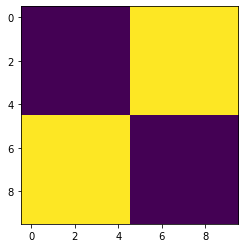

In [11]:
print(metal_grid)
print(f"Size of the grid: {metal_grid.size}")
plt.imshow(metal_grid)

Horizontal shear attempted in line 6
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 6
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 1
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 1!
[[1 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]]


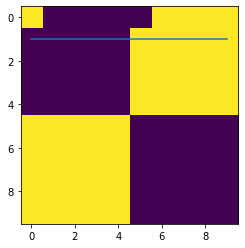

In [12]:
shear_counts_horizontal = np.zeros(grid_size, dtype=np.int64)
shear_counts_vertical   = np.zeros(grid_size, dtype=np.int64)

shear_line = shear_step(metal_grid              = metal_grid,
                        shear_counts_horizontal = shear_counts_horizontal,
                        shear_counts_vertical   = shear_counts_vertical, 
                        shear_type              = 0,
                        strength_A              = 1,
                        strength_B              = 0.2,
                        max_attempts            = 100)
print(metal_grid)
plt.imshow(metal_grid)
plt.plot( [0, metal_grid.shape[1]-1], [shear_line, shear_line], "-")

Horizontal shear attempted in line 2
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 2!
Step 0
[[1 1 0 0 0 0 0 1 1 1]
 [1 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]]


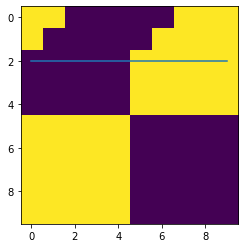

Horizontal shear attempted in line 3
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 3!
Step 1
[[1 1 1 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 1 1 1]
 [1 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]]


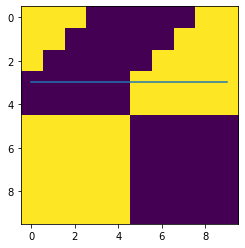

Horizontal shear attempted in line 4
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 4!
Step 2
[[1 1 1 1 0 0 0 0 0 1]
 [1 1 1 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 1 1 1]
 [1 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]]


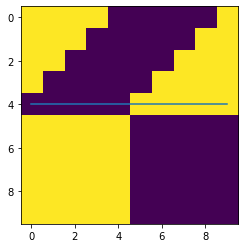

Horizontal shear attempted in line 5
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 5!
Step 3
[[1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 1]
 [1 1 1 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 1 1 1]
 [1 0 0 0 0 0 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]]


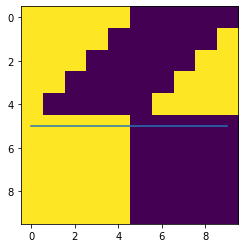

Horizontal shear attempted in line 9
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 7
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 7!
Step 4
[[0 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 1]
 [1 1 1 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 1 1 1]
 [0 1 1 1 1 1 0 0 0 0]
 [0 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]]


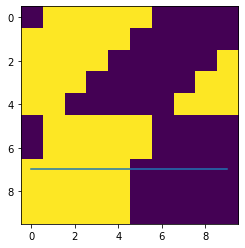

Horizontal shear attempted in line 1
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 1!
Step 5
[[0 0 1 1 1 1 1 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 1]
 [1 1 1 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 1 1 1]
 [0 1 1 1 1 1 0 0 0 0]
 [0 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]]


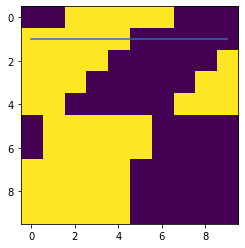

Horizontal shear attempted in line 4
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 4!
Step 6
[[0 0 0 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 1 1 1]
 [0 1 1 1 1 1 0 0 0 0]
 [0 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]]


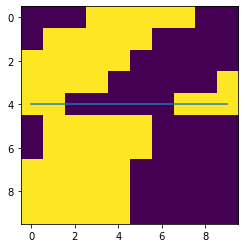

Horizontal shear attempted in line 9
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 6
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 6!
Step 7
[[0 0 0 0 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 0 0 0]
 [0 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 1 1]
 [0 0 1 1 1 1 1 0 0 0]
 [0 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]]


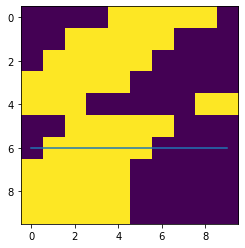

Horizontal shear attempted in line 1
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 4
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 8
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 4
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 0
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 4
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 5
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 1
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 1!
Step 8
[[0 0 0 0 0 1 1 1 1 1]
 [0 0 1 1 1 1 1 0 0 0]
 [0 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 1 1]
 [0 0 1

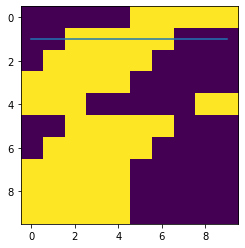

Horizontal shear attempted in line 9
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 9
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 9!
Step 9
[[1 0 0 0 0 0 1 1 1 1]
 [0 0 0 1 1 1 1 1 0 0]
 [0 0 1 1 1 1 1 0 0 0]
 [0 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 1]
 [0 0 0 1 1 1 1 1 0 0]
 [0 0 1 1 1 1 1 0 0 0]
 [0 1 1 1 1 1 0 0 0 0]
 [0 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]]


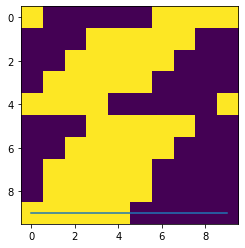

In [13]:
for i in range(10):
    shear_line = shear_step(metal_grid              = metal_grid,
                        shear_counts_horizontal = shear_counts_horizontal,
                        shear_counts_vertical   = shear_counts_vertical, 
                        shear_type              = 0,
                        strength_A              = 1,
                        strength_B              = 0.2,
                        max_attempts            = 100)
    
    print(f"Step {i}")
    print(metal_grid)
    #print(f"Size of the grid: {grid.size}")
    plt.figure()
    plt.imshow(metal_grid)
    plt.plot( [0, metal_grid.shape[1]-1], [shear_line, shear_line], "-")
    plt.show()

---
### def calculate_metal_metal_interaction_energy(x, y, grid, E_same, E_diff):

#### Physical Interpretation:

Calculation of the interaction energy of an atom with its 4 surrounding atoms. This function is essential for calculating the energy in the diffusion step, i.e., if such a step is energetically favorable or or not.
    
---

In [14]:
# Function to calculate local energy around a site (x, y), considering periodic boundary conditions
def calculate_metal_metal_interaction_energy(x, y, metal_grid, E_AA, E_BB, E_AB):
    """
    The energy is calculated based on the type of the neighboring atom:
    If the neighboring atom is the same type as the current atom, the corresponding interaction energy (E_AA or E_BB) is added.
    If the neighboring atom is a different type, the E_AB interaction energy is added.
    
    Parameters
    - x               : int, x-position of site where to calculate the energy.
    - y               : int, y-position of site where to calculate the energy.
    - metal_grid      : np.array, 2D array representing the atom positions (0 for A, 1 for B).
    - E_AA            : float, interaction energy between A-A atoms.
    - E_BB            : float, interaction energy between B-B atoms.
    - E_AB            : float, interaction energy between A-B atoms.
    
    Returns:
    - energy          : float, interaction energy derived from site (x, y).
    """
    energy = 0
    atom = metal_grid[x, y]  # Atom type at the target site (0 for A, 1 for B)
    
    # Define neighbors (up, down, left, right)
    neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]
    
    for nx, ny in neighbors:
        # Apply periodic boundary conditions to neighbors
        nx = nx % metal_grid.shape[0]  # Wrap around the x-coordinate
        ny = ny % metal_grid.shape[1]  # Wrap around the y-coordinate
        
        # Get the neighboring atom after applying periodic boundary conditions
        neighbor_atom = metal_grid[nx, ny]
        
        # Calculate the energy contribution based on the interaction type
        if atom == 0 and neighbor_atom == 0:  # A-A interaction
            energy += E_AA
        elif atom == 1 and neighbor_atom == 1:  # B-B interaction
            energy += E_BB
        else:  # A-B or B-A interaction
            energy += E_AB
    
    return energy

#### Demonstration

In [15]:
# If you want to start a new simulation you can re-initialize the grid here
grid_size = 10
metal_grid = initialize_metal_grid(grid_size)


print(metal_grid)

[[0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]]


In [16]:
E_AA, E_BB, E_AB = -1, -2, 3

calculate_metal_metal_interaction_energy(2, 5, metal_grid, E_AA, E_BB, E_AB)

-3

---
### def calculate_total_metal_metal_interaction_energy(grid, E_same, E_diff):

Physical Interpretation:

This function calculates the total interaction energy of the grid, ensuring that each pair of interacting atoms contributes to the energy only once and that interactions across grid boundaries are correctly accounted for using periodic boundary conditions.

---

In [17]:
# Function to calculate total energy of the grid, considering periodic boundary conditions
def calculate_total_metal_metal_interaction_energy(metal_grid, E_AA, E_BB, E_AB):
    """
    Vectorized calculation of the total energy of the grid, 
    considering interactions with right and down neighbors only.
    
    Parameters:
    - metal_grid         : np.array, 2D array representing the atom positions (0 for A, 1 for B).
    - E_AA               : float, interaction energy between A-A atoms.
    - E_BB               : float, interaction energy between B-B atoms.
    - E_AB               : float, interaction energy between A-B atoms.
    
    Returns:
    - total_energy       : float, interaction energy summed up over the whole grid.
    """
    # Shifted grids for right and down neighbors, with periodic boundaries
    right_neighbors = np.roll(metal_grid, shift=-1, axis=1)  # Right neighbors
    down_neighbors = np.roll(metal_grid, shift=-1, axis=0)   # Down neighbors

    # Calculate interactions for right neighbors
    interaction_AA_right = (metal_grid == 0) & (right_neighbors == 0)  # A-A interactions
    interaction_BB_right = (metal_grid == 1) & (right_neighbors == 1)  # B-B interactions
    interaction_AB_right = (metal_grid != right_neighbors)             # A-B interactions

    # Calculate interactions for down neighbors
    interaction_AA_down = (metal_grid == 0) & (down_neighbors == 0)    # A-A interactions
    interaction_BB_down = (metal_grid == 1) & (down_neighbors == 1)    # B-B interactions
    interaction_AB_down = (metal_grid != down_neighbors)               # A-B interactions

    # Total energy contributions
    total_energy_right = (
        np.sum(interaction_AA_right) * E_AA +
        np.sum(interaction_BB_right) * E_BB +
        np.sum(interaction_AB_right) * E_AB
    )

    total_energy_down = (
        np.sum(interaction_AA_down) * E_AA +
        np.sum(interaction_BB_down) * E_BB +
        np.sum(interaction_AB_down) * E_AB
    )

    # Sum total energy contributions
    total_energy = total_energy_right + total_energy_down

    return total_energy

#### Demonstration

In [18]:
# If you want to start a new simulation you can re-initialize the grid here
grid_size = 4
metal_grid = initialize_metal_grid(grid_size)

print(metal_grid)

[[0 0 1 1]
 [0 0 1 1]
 [1 1 0 0]
 [1 1 0 0]]


In [19]:
calculate_total_metal_metal_interaction_energy(metal_grid, E_AA=-0.1, E_BB=-0.5, E_AB=2)

27.2

#### Demonstration+ - Physical interpretation of energy input and output values.

In [20]:
# If you want to start a new simulation you can re-initialize the grid here
grid_size = 2
metal_grid = initialize_metal_grid(grid_size)


print(metal_grid)

[[0 1]
 [1 0]]


In [21]:
# This is the mixing enthalpy that is used as an input for the MC simulation.
# It represent the energy that is gained by an atom if completely dissolved in a solid solution, i.e., if an/every A atoms is surrounded by 4 B atoms.
dHmix = 4

# Therefore the enthalpy has to be normalized to the number of potential bonds, i.e., 4.
# Because every bond counts for the energy of 2 atoms, a factor of 2 has to be added here.
dHmix_bond = 2 * 4/4

# We sum up over all bonds. By the current method, double counting bond is omitted, i.e., we sum up over 8 (not 4*4=16) bond in a 2x2 grid.
Total_energy_out = calculate_total_metal_metal_interaction_energy(metal_grid, E_AA=0, E_BB=0, E_AB=dHmix_bond) #

dHmix_out = Total_energy_out / metal_grid.size
dHmix_out

4.0

---
### def metal_diffusion_step(grid, kT, E_same, E_diff):

#### Physical Interpretation:

This Monte Carlo diffusion step models atom movement on the grid based on energy considerations.

Atoms attempt to move (swap) with their neighbors, and the system only accepts moves that lead to a lower energy or those that are energetically unfavorable but are allowed with some probability (depending on temperature).

This step mimics diffusion processes in real materials, where atoms move in response to local energy differences, but thermal fluctuations (controlled by kT) also allow atoms to occasionally move to higher-energy positions.

Over many MC steps, this process leads to the gradual evolution of the system toward thermodynamic equilibrium, where the distribution of atoms tends to minimize the overall energy.

This MC simulation uses the metropolis algorithm. Step lowering the energy are always accepted, steps increasing the energy are accepted with a certain probability depending on the energy difference and kT.
https://de.wikipedia.org/wiki/Metropolis-Algorithmus
    
---

In [22]:
def metal_diffusion_step(metal_grid, kT, E_AA, E_BB, E_AB, grid_size):
    """
    Perform a single MC step by trying to swap two neighboring atoms
    This defines a function called metal_diffusion_step(), which takes
    four arguments:

    Parameters:
    - metal_grid               : np.array, 2D array representing the atom positions (either A or B).
    - kT                 : float, thermal energy factor (k is the Boltzmann constant, T is temperature). It controls how likely energetically unfavorable moves are accepted (higher temperatures allow more such moves).
    - E_AA               : float, interaction energy between A-A atoms.
    - E_BB               : float, interaction energy between B-B atoms.
    - E_AB               : float, interaction energy between A-B atoms.
    
    Returns:
    - accept             : True if the MC step was accepted
    """

    # Choose a random position on the metal_grid
    x, y = np.random.randint(0, grid_size), np.random.randint(0, grid_size)

    # Select a random neighbor (up, down, left, right)
    direction = np.random.randint(0, 4)
    if direction == 0: nx, ny = (x - 1) % grid_size, y  # Up
    elif direction == 1: nx, ny = (x + 1) % grid_size, y  # Down
    elif direction == 2: nx, ny = x, (y - 1) % grid_size  # Left
    else: nx, ny = x, (y + 1) % grid_size  # Right

    if metal_grid[x, y] == metal_grid[nx, ny]:
        print("Successful self-diffusion - No changes expected!")
        return True, x, y, nx, ny # x, y, nx, ny - Returns this only in Tutorial

    # Calculate the initial energy before swap
    initial_energy = calculate_metal_metal_interaction_energy(x ,  y, metal_grid, E_AA, E_BB, E_AB) + \
                     calculate_metal_metal_interaction_energy(nx, ny, metal_grid, E_AA, E_BB, E_AB)
    
    # Swap atoms
    metal_grid[x, y], metal_grid[nx, ny] = metal_grid[nx, ny], metal_grid[x, y]
    
    # Calculate the new energy after swap
    final_energy = calculate_metal_metal_interaction_energy(x ,  y, metal_grid, E_AA, E_BB, E_AB) + \
                   calculate_metal_metal_interaction_energy(nx, ny, metal_grid, E_AA, E_BB, E_AB)
    
    # Calculate the change in energy
    delta_E = final_energy - initial_energy
    
    print(f"Trying to swap positions ({x},{y}) with ({nx},{ny}) - The change in energy is {delta_E}")
    
    accept = True
    # Metropolis criterion: accept swap with probability exp(-delta_E / kT)
    if delta_E > 0 and np.exp(-delta_E / kT) < np.random.rand():
        # Reject the swap (reverse it)
        metal_grid[x, y], metal_grid[nx, ny] = metal_grid[nx, ny], metal_grid[x, y]
        accept = False
        
    if accept == True:
        print("Jump accepted!")
    else:
        print("Jump rejected!")
        
    return accept, x, y, nx, ny # x, y, nx, ny - Returns this only in Tutorial

#### Demonstration

In [23]:
# If you want to start a new simulation you can re-initialize the grid here
grid_size = 10
metal_grid = initialize_metal_grid(grid_size)


print(metal_grid)

[[0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]]


Successful self-diffusion - No changes expected!


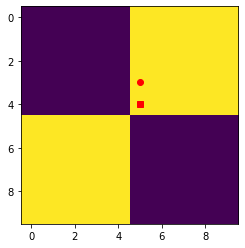

Successful self-diffusion - No changes expected!


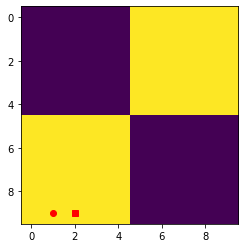

Successful self-diffusion - No changes expected!


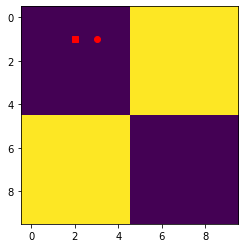

Successful self-diffusion - No changes expected!


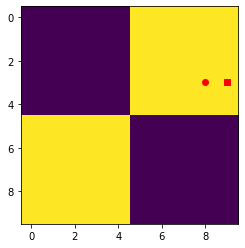

Successful self-diffusion - No changes expected!


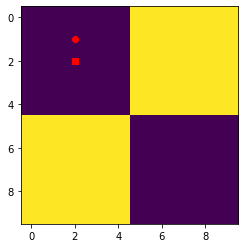

Successful self-diffusion - No changes expected!


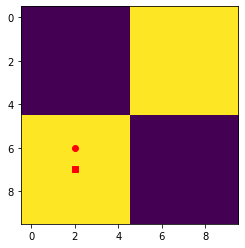

Successful self-diffusion - No changes expected!


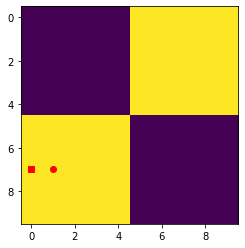

Successful self-diffusion - No changes expected!


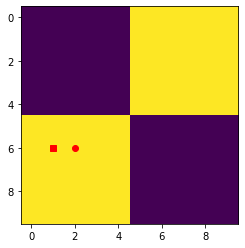

Successful self-diffusion - No changes expected!


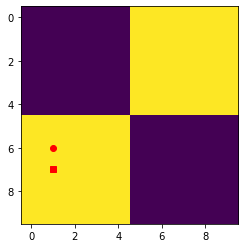

Successful self-diffusion - No changes expected!


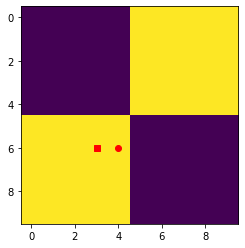

[[0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]]


In [24]:
# Initialize counter for successful jumps
successful_jumps = 0
total_steps = 10  # Total number of Monte Carlo steps


for i in range(total_steps):
    # Save the state of the grid before attempting the Monte Carlo step
    previous_grid = metal_grid.copy()
    
    # Perform one Monte Carlo step
    _, x, y, nx, ny = metal_diffusion_step(metal_grid, 1, +1, +1, -1, grid_size) # kT, E_AA, E_BB, E_AB

    plt.figure()
    plt.imshow(metal_grid)
    plt.plot(y ,  x, "o", color="red")
    plt.plot(ny, nx, "s", color="red")
    plt.show()

# Print the final grid
print(metal_grid)

### def calculate_mixing_index(grid):

#### Physical Interpretation:

The Mixing Index measures the degree of mixing between two types of atoms (A and B). A value of 0 indicates complete segregation (no A-B pairs), while a value close to 1 indicates maximal mixing (many A-B pairs).


In [25]:
# Function to calculate the mixing index of the grid, considering periodic boundary conditions
def calculate_mixing_index(grid):
    """
    Vectorized calculation of the Mixing Index.
    The Mixing Index is the proportion of different neighboring pairs (A-B pairs).
    0   - Perfect seperation, no A-B neighbors
    0.5 - random solution
    1   - Perfect intermixing, only A-B neighbors
    
    Parameters:
    - grid                : np.array, 2D array representing the atom positions (either A or B).
       
    Returns:
    - mixing index        : float, represents the state of mixing / order of the current grid
    """
    # Shifted grids for right and down neighbors, with periodic boundaries
    right_neighbors = np.roll(grid, shift=-1, axis=1)
    down_neighbors = np.roll(grid, shift=-1, axis=0)

    # Calculate A-B pairs
    ab_pairs_right = grid != right_neighbors
    ab_pairs_down = grid != down_neighbors

    # Total pairs are grid_size^2 for both right and down neighbors (no double-counting)
    total_pairs = 2 * grid.size
    ab_pairs = np.sum(ab_pairs_right) + np.sum(ab_pairs_down)

    return ab_pairs / total_pairs

#### Demonstration

A perfectly order grid results in a mixing index of 1.

[[0 1 0 1]
 [1 0 1 0]
 [0 1 0 1]
 [1 0 1 0]]


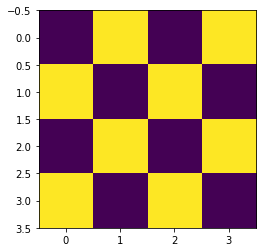

1.0

In [26]:
# If you want to start a new simulation you can re-initialize the grid here
#grid_size = 10
#grid = initialize_metal_grid(grid_size)

grid_size = 4
grid = np.array([[0,1,0,1],
                 [1,0,1,0],
                 [0,1,0,1],
                 [1,0,1,0]])
print(grid)
plt.figure()
plt.imshow(grid)
plt.show()

calculate_mixing_index(grid)



A well seperated grid results in a mixing index close to zero. Since some A-B neighbors will always be present (exept if you only have A or B atoms) the mixing index will never the exactly zero.

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


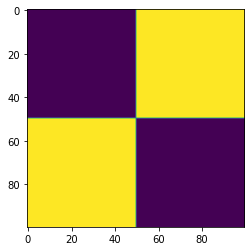

0.02

In [27]:
# If you want to start a new simulation you can re-initialize the grid here
grid_size = 100
grid = initialize_metal_grid(grid_size)

print(grid)
plt.figure()
plt.imshow(grid)
plt.show()

calculate_mixing_index(grid)

Making a large random grid results in a mixing index approaching 0.5.
The mixing index will closer to 0.5 the larger the grid.

[[0 1 1 ... 1 1 1]
 [0 0 0 ... 1 0 0]
 [1 0 1 ... 0 1 0]
 ...
 [0 1 1 ... 0 0 1]
 [1 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]]


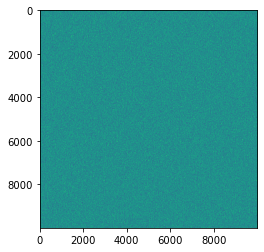

0.49994112

In [28]:
# Parameters
grid_size = 10000  # Adjust the size of the grid as needed

# Generate a random 2D grid with 0s and 1s
grid = np.random.randint(2, size=(grid_size, grid_size))

print(grid)
plt.figure()
plt.imshow(grid)
plt.show()

calculate_mixing_index(grid)

### def sample_energy(E_mean, E_std):

#### Physical Interpretation:

This varies the interaction energies based on a normal distribution to obtain more general and reliable results, i.e., results that are less sensitive to a particular set of interaction energies.

In [29]:
# Function to sample energy values from a normal distribution
def sample_energy(E_mean, E_std):
    """Function to sample interaction energies from a normal distribution
    
    Parameters:
        
    - E_mean          : float, mean value of the normal distribution
    - E_std           : float, Standard deviation of the normal distribution
    
    Returns:
    - E               : float, energy sample drawn form a normal distribution
    """
    return np.random.normal(E_mean, E_std)

#### Demonstration

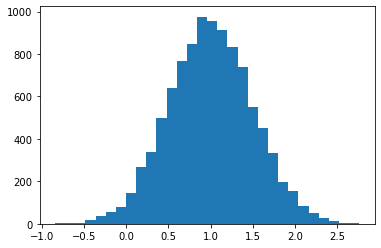

In [30]:
E_sample = []
for i in range(10000):
    E_sample.append(sample_energy(1, 0.5))
    
hist = plt.hist(E_sample, bins=30)

### def get_sampling_interval(n_mc_steps):

#### Physical Interpretation:

No physical interpretation - Reduce sampling frequency at larger MC steps in order to reduce the memory usage and increase computational efficiency.

In [31]:
# To make the frequency of energy and mixing index calculations dependent on the total number of Monte Carlo (MC) steps,
# you can adjust the interval dynamically based on the total `n_mc_steps`. Here's an implementation of that:
def get_sampling_interval(n_mc_steps):
    """
    Function to determine the sampling interval for calculating energy and mixing index
    based on the total number of MC steps.
    
    The higher the number of MC steps, the less frequent the sampling will be.
    
    Parameters:
    - n_mc_steps           : int, current MC step
    
    Returns:
    - sampling_interval    : int, sampling interval for saving data and checking convergence based on current MC step
    """
    # Define a scaling factor or logic to decrease sampling frequency as n_mc_steps increases
    if n_mc_steps   <= 100:
        return 5      # Sample every 5 steps for smaller simulations
    if n_mc_steps   <= 1000:
        return 50     # Sample every 50 steps for smaller simulations
    elif n_mc_steps <= 10000:
        return 500    # Sample every 500 steps for mid-range simulations
    elif n_mc_steps <= 100000:
        return 5000   # Sample every 5000 steps for larger simulations
    elif n_mc_steps <= 1000000:
        return 10000  # Sample every 50000 steps for larger simulations
    else:
        return 25000  # Sample every 100000 steps for larger simulations

#### Demonstration

In [32]:
get_sampling_interval(100000000)

25000

# Metal - Hydrogen System

Function to initialize the hydrogen grid (H atoms near A atoms)  - NOT USED IN SIMULATION - FOR TUTORIAL

`def initialize_hydrogen_grid(grid_size):`

---

Function to perform a shear step (mechanical intermixing) with flow strength weighting

`def shear_step_with_hydrogen(metal_grid, hydrogen_grid, shear_type="both", strength_A=1, strength_B=0.2, shear_counts_horizontal=None, shear_counts_vertical=None):`

---

Function to calculate interaction energy between a specific metal atom and neighboring hydrogen sites

`def calculate_metal_hydrogen_interaction_energy(x, y, metal_grid, hydrogen_grid, E_AH, E_BH):`

---

Function to calculate interaction energy of a specific hydrogen atoms / site with surrounding metals, including periodic boundary conditions

`def calculate_hydrogen_metal_interaction_energy(x, y, hydrogen_grid, metal_grid, E_AH, E_BH):`

---

Function that sums up all the interaction energies between hydrogen and metals

`def calculate_total_metal_hydrogen_interaction_energy(metal_grid, hydrogen_grid, E_AH, E_BH):`

---

Function to perform a metal diffusion step considering both metal-metal and metal-hydrogen interactions with periodic boundary conditions

`def metal_diffusion_step_with_hydrogen(metal_grid, hydrogen_grid, kT, E_same, E_diff, E_AH, E_BH):`


---
Function to perform a metal diffusion step considering both metal-hydrogen interactions with periodic boundary conditions

`def hydrogen_diffusion_step(hydrogen_grid, metal_grid, kT, E_AH, E_BH):`




---
### def initialize_hydrogen_grid():

#### Physical Interpretation:

Hydrogen atoms are now positioned in interstitial sites near A atoms in the top-left and bottom-right quadrants.

The grid size remains the same as the metal grid, ensuring that periodic boundary conditions are correctly applied when atoms at the boundaries interact with atoms on the opposite side.

###### H atoms, near A atoms - 1 in the hydrogen grid (i.e., 0 in the metal grid)

###### Vacancies or vacant intersitial sites, near B atoms - 0 in the hydrogen grid (i.e., 1 in the metal grid)


Repetion from the metal grid definition:

###### A atoms, e.g., TiVZrNbHf - 0

###### B atoms, e.g., Cu - 1

---


In [33]:
# Function to initialize the hydrogen grid (H atoms near A atoms)
def initialize_hydrogen_grid(grid_size):
    """
    The hydrogen grid will have the same size as the metal grid.
    We will place hydrogen atoms near A atoms (=0), but ensure that the
    hydrogen atoms occupy interstitial sites at the boundary as well
    (effectively wrapping the grid).
    Hydrogen atoms are represented by 1, a vacant interstitial site by 0.
    Therefore, the hydrogen grid will effectively be the inverted version of the original metal grid,
    i.e., H atoms (=1) will be on top of A atoms (=0), and vacancies (=0) will be on top of B atoms(=1).
    
    Parameters: 
    - grid_size:          int, size of the hydrogen grid, should be the same as that of the metal grid
    
    Returns
    - hydrogen_grid       2D np.array, grid representing the hydrogen atoms, 0 is a vacancy, 1 is a hydrogen atom
    """
    # Initialize a grid of the same size as the metal grid
    hydrogen_grid = np.zeros((grid_size, grid_size), dtype=np.int64)
    
    # Place hydrogen near A atoms, with periodic boundary conditions
    # Top-left quadrant (A atoms)
    hydrogen_grid[:grid_size // 2, :grid_size // 2] = 1  # Hydrogen near A atoms (Top-left)
    
    # Bottom-right quadrant (A atoms)
    hydrogen_grid[grid_size // 2:, grid_size // 2:] = 1  # Hydrogen near A atoms (Bottom-right)
    
    return hydrogen_grid

#### Demonstration

In [34]:
grid_size = 10
hydrogen_grid = initialize_hydrogen_grid(grid_size)
print(hydrogen_grid)

[[1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]]


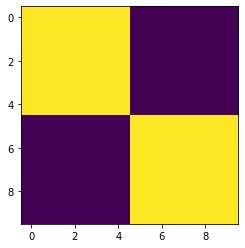

In [35]:
# Plot grid to show that the Numpy Array
plt.imshow(hydrogen_grid)

One can see here that the pattern is inverted from the pattern (1.example) of the metal grid, meaning that the hydrogen sites are at the sites close to the A atoms (0 in the metal grid).

#### Demonstrations+

In the MC simulation using the representative real starting configuation, the inverted nature of the hydrogen grid can be used to calculate it from the metal grid in a simple fashion.

In [36]:
grid_size = 100

FILEPATH_STARTING_CONFIGURATION = "Real_starting_conf.png"
metal_grid = initialize_grid_from_image(FILEPATH_STARTING_CONFIGURATION, grid_size)
metal_grid

array([[0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 1]], dtype=int64)

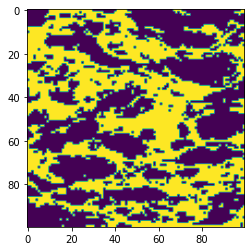

In [37]:
plt.imshow(metal_grid)

In [38]:
hydrogen_grid = 1 - metal_grid

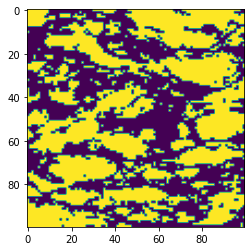

In [39]:
plt.imshow(hydrogen_grid)

---
### def shear_step_with_hydrogen():

#### Physical Interpretation:

Updated version of def shear_step(grid) that simultaniously shifts the metal and the hydrogen sub-grids.

In [40]:
# Function to perform a shear step (mechanical intermixing) with flow strength weighting
def shear_step_with_hydrogen(metal_grid, hydrogen_grid, shear_counts_horizontal, shear_counts_vertical, 
                             shear_type, strength_A, strength_B, max_attempts):
    """
    Perform a shear step with probability weighted by the cumulative strength of atoms along the shear line.
    This function enforces that at least one shear step occurs.

    Parameters:
    - metal_grid              : np.array, 2D grid of metal atoms (0 for A, 1 for B).
    - hydrogen_grid           : np.array, 2D grid of hydrogen atoms (1 for H, 0 for empty).
    - shear_counts_horizontal : np.array, tracks horizontal shear steps per row.
    - shear_counts_vertical   : np.array, tracks vertical shear steps per column.
    - shear_type              : int, 0 for horizontal, 1 for vertical, 2 for random selection.
    - strength_A              : float, flow strength (hardness) of metal type A.
    - strength_B              : float, flow strength (hardness) of metal type B.
    - max_attempts            : int, maximum attempts to find a suitable shear location before forcing it.

    Returns:
    - int: The row or column index where shear occurred.
    """

    grid_size_x, grid_size_y = metal_grid.shape

    # **Optimized Shear Type Selection**
    if shear_type == 2:
        horizontal_shear = np.random.rand() < 0.5  # 50% chance of horizontal shear
    else:
        horizontal_shear = shear_type == 0

    # Maximum strength normalization factor
    max_strength = 2 * max(strength_A, strength_B) * (grid_size_y if horizontal_shear else grid_size_x)

    # Attempt up to `max_attempts` times to perform a shear step
    for _ in range(max_attempts):
        if horizontal_shear:
            # Pick a random row
            line = np.random.randint(0, grid_size_x)
            print(f"Horizontal shear attempted in line {line}")

            # Compute shear probability (vectorized)
            cumulative_strength = np.sum((metal_grid[line, :] == 0) * strength_A + (metal_grid[line, :] == 1) * strength_B) + \
                                  np.sum((metal_grid[(line - 1) % grid_size_x, :] == 0) * strength_A + (metal_grid[(line - 1) % grid_size_x, :] == 1) * strength_B)
            
            shear_probability = 1.0 - (cumulative_strength / max_strength)
            print(f"Cumulative strength is {cumulative_strength:.1f} and the shear probabiliy therefore {shear_probability:.1f}")

            # Perform shear step if probability is met or at last attempt
            if np.random.rand() < shear_probability or _ == max_attempts - 1:
                print(f"Horizontal shear successful at line {line}!")

                # Efficient row shifting using pure NumPy indexing
                last_col_metal = metal_grid[:line, -1].copy()  # Store last column
                metal_grid[:line, 1:] = metal_grid[:line, :-1]  # Shift right
                metal_grid[:line, 0] = last_col_metal  # Wrap-around

                last_col_hydrogen = hydrogen_grid[:line, -1].copy()  # Store last column
                hydrogen_grid[:line, 1:] = hydrogen_grid[:line, :-1]  # Shift right
                hydrogen_grid[:line, 0] = last_col_hydrogen  # Wrap-around

                shear_counts_horizontal[line] += 1  
                return line  # Return immediately after successful shear

        else:
            # Pick a random column
            line = np.random.randint(0, grid_size_y)
            print(f"Vertical shear attempted in line {line}")
            
            # Compute shear probability (vectorized)
            cumulative_strength = np.sum((metal_grid[:, line] == 0) * strength_A + (metal_grid[:, line] == 1) * strength_B) + \
                                  np.sum((metal_grid[:, (line - 1) % grid_size_y] == 0) * strength_A + (metal_grid[:, (line - 1) % grid_size_y] == 1) * strength_B)
            
            shear_probability = 1.0 - (cumulative_strength / max_strength)
            print(f"Cumulative strength is {cumulative_strength:.1f} and the shear probabiliy therefore {shear_probability:.1f}")

            # Perform shear step if probability is met or at last attempt
            if np.random.rand() < shear_probability or _ == max_attempts - 1:
                print(f"Vertical shear successful at line {line}!")
                
                # Efficient column shifting using pure NumPy indexing
                last_row_metal = metal_grid[-1, :line].copy()  # Store last row
                metal_grid[1:, :line] = metal_grid[:-1, :line]  # Shift down
                metal_grid[0, :line] = last_row_metal  # Wrap-around

                last_row_hydrogen = hydrogen_grid[-1, :line].copy()  # Store last row
                hydrogen_grid[1:, :line] = hydrogen_grid[:-1, :line]  # Shift down
                hydrogen_grid[0, :line] = last_row_hydrogen  # Wrap-around

                shear_counts_vertical[line] += 1  
                return line  # Return immediately after successful shear

#### Demonstration

In [41]:
# If you want to start a new simulation you can re-initialize the grid here
grid_size = 10
metal_grid = initialize_metal_grid(grid_size)
hydrogen_grid = initialize_hydrogen_grid(grid_size)

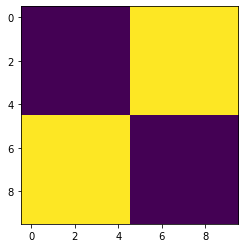

In [42]:
plt.imshow(metal_grid)

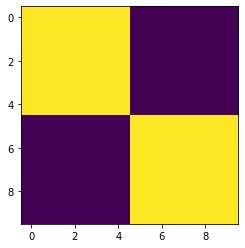

In [43]:
plt.imshow(hydrogen_grid)

In [44]:
shear_counts_horizontal = np.zeros(grid_size, dtype=np.int64)
shear_counts_vertical   = np.zeros(grid_size, dtype=np.int64)

shear_line = shear_step_with_hydrogen(metal_grid              = metal_grid,
                                      hydrogen_grid           = hydrogen_grid,
                                      shear_counts_horizontal = shear_counts_horizontal,
                                      shear_counts_vertical   = shear_counts_vertical, 
                                      shear_type              = 0,
                                      strength_A              = 1,
                                      strength_B              = 0.2,
                                      max_attempts            = 10)

Horizontal shear attempted in line 7
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 7!


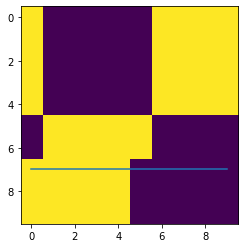

In [45]:
plt.imshow(metal_grid)
plt.plot( [0, metal_grid.shape[1]-1], [shear_line, shear_line], "-")

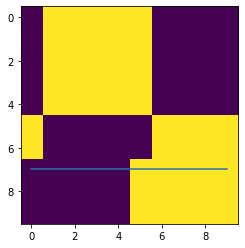

In [46]:
plt.imshow(hydrogen_grid)
plt.plot( [0, hydrogen_grid.shape[1]-1], [shear_line, shear_line], "-")

Horizontal shear attempted in line 9
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 2
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 0
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 0!
Step 0


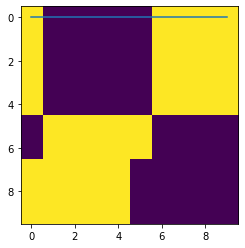

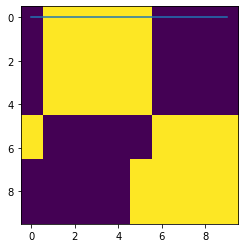

Horizontal shear attempted in line 0
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 0!
Step 1


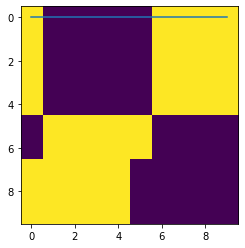

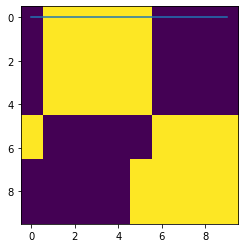

Horizontal shear attempted in line 2
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 4
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 4!
Step 2


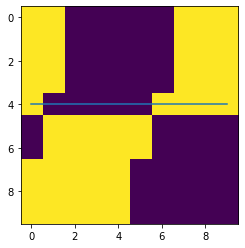

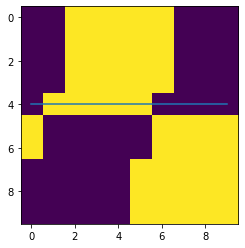

Horizontal shear attempted in line 0
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 3
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 3
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 2
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 2!
Step 3


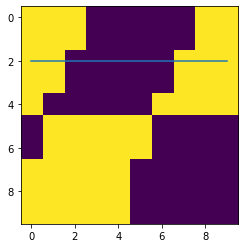

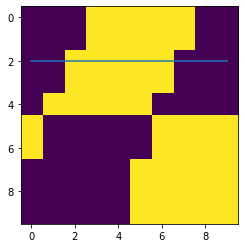

Horizontal shear attempted in line 4
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 4!
Step 4


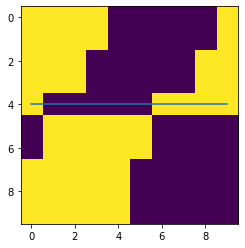

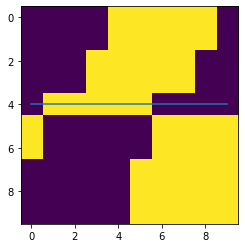

Horizontal shear attempted in line 2
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 2!
Step 5


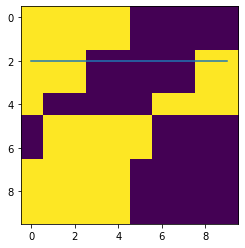

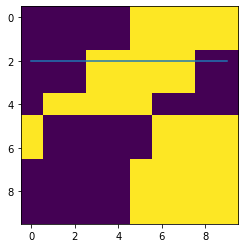

Horizontal shear attempted in line 0
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 1
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 2
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 9
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 3
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 1
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 0
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 0!
Step 6


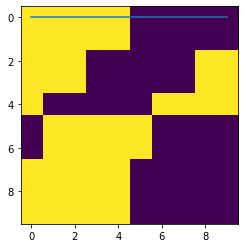

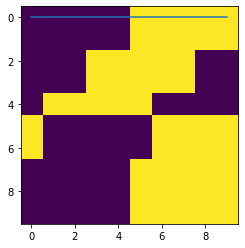

Horizontal shear attempted in line 2
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 2!
Step 7


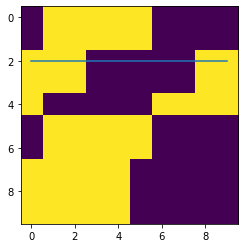

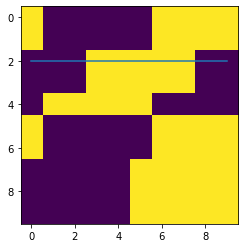

Horizontal shear attempted in line 9
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 4
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear attempted in line 1
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 1!
Step 8


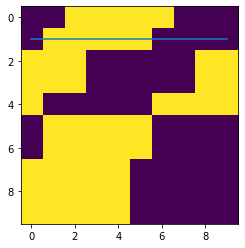

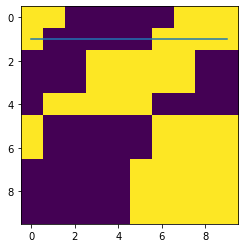

Horizontal shear attempted in line 6
Cumulative strength is 12.0 and the shear probabiliy therefore 0.4
Horizontal shear successful at line 6!
Step 9


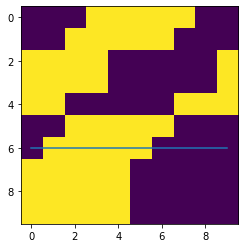

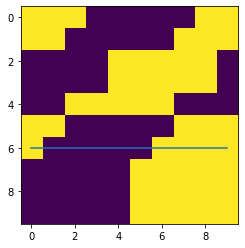

In [47]:
shear_counts_horizontal = np.zeros(grid_size, dtype=np.int64)
shear_counts_vertical   = np.zeros(grid_size, dtype=np.int64)

for i in range(10):
    shear_line = shear_step_with_hydrogen(metal_grid              = metal_grid,
                                          hydrogen_grid           = hydrogen_grid,
                                          shear_counts_horizontal = shear_counts_horizontal,
                                          shear_counts_vertical   = shear_counts_vertical, 
                                          shear_type              = 0,
                                          strength_A              = 1,
                                          strength_B              = 0.2,
                                          max_attempts            = 10)
    print(f"Step {i}")
    #print(metal_grid)
    #print(f"Size of the grid: {grid.size}")
    plt.figure()
    plt.imshow(metal_grid)
    plt.plot( [0, metal_grid.shape[1]-1], [shear_line, shear_line], "-")
    plt.show()
    plt.imshow(hydrogen_grid)
    plt.plot( [0, metal_grid.shape[1]-1], [shear_line, shear_line], "-")
    plt.show()

---

### def calculate_metal_hydrogen_interaction_energy(x, y, metal_grid, hydrogen_grid, E_AH, E_BH):

#### Physical Interpretation:

The function now correctly computes the interaction energy between ***a single metal atom and its surrounding hydrogen atoms***, taking periodic boundary conditions into account. This means that hydrogen atoms on the opposite edges of the grid will still interact with metal atoms near the boundaries.

---

In [48]:
# Function to calculate interaction energy between metal atom and neighboring hydrogen sites
def calculate_metal_hydrogen_interaction_energy(x, y, metal_grid, hydrogen_grid, E_AH, E_BH):
    """
    Function to calculate the interaction energy between a metal atom and its neighboring hydrogen sites.
    The function considers the four interstitial hydrogen sites surrounding the metal atom, and accounts 
    for periodic boundary conditions to ensure correct interactions at the grid boundaries.
    
    Parameters:
    x, y:                  int, Coordinates of the metal atom on the metal grid.
    metal_grid:            2D numpy array, grid representing metal atoms (A and B) in the system.
    hydrogen_grid:         2D numpy array, grid representing the presence of hydrogen atoms in the interstitial sites.
    E_AH:                  float, interaction energy between metal A atoms and hydrogen.
    E_BH:                  float, interaction energy between metal B atoms and hydrogen.
    
    Returns:
    energy:                float, total interaction energy between the metal atom and its neighboring hydrogen sites.
    """
    energy = 0
    # Define the four neighboring hydrogen sites around the metal atom
    neighbors = [(x, y), (x, (y-1) % grid_size), ((x-1) % grid_size, y), ((x-1) % grid_size, (y-1) % grid_size)]
    
    metal = metal_grid[x, y]  # Get the metal type (A or B)
    
    # Loop over the neighbors and calculate the interaction energy
    for nx, ny in neighbors:
        hydrogen_site = hydrogen_grid[nx, ny]
        if hydrogen_site == 1:  # Check if hydrogen is present
            if metal == 0:  # Metal A
                energy += E_AH
            else:  # Metal B
                energy += E_BH
    
    return energy

#### Demonstration

In [49]:
# If you want to start a new simulation you can re-initialize the grid here
grid_size = 4
metal_grid = initialize_metal_grid(grid_size)
hydrogen_grid = initialize_hydrogen_grid(grid_size)

In [50]:
print(metal_grid)
print(f"Size of the grid: {metal_grid.size}")

[[0 0 1 1]
 [0 0 1 1]
 [1 1 0 0]
 [1 1 0 0]]
Size of the grid: 16


In [51]:
print(hydrogen_grid)
print(f"Size of the grid: {hydrogen_grid.size}")

[[1 1 0 0]
 [1 1 0 0]
 [0 0 1 1]
 [0 0 1 1]]
Size of the grid: 16


In [52]:
calculate_metal_hydrogen_interaction_energy(1, 3, metal_grid, hydrogen_grid, E_AH=-1, E_BH=0.5)

0

---
### metal_diffusion_step_with_hydrogen(metal_grid, hydrogen_grid, kT, E_same, E_diff, E_AH, E_BH):

#### Physical Interpretation:

This Monte Carlo diffusion step models atom movement on the grid based on energy considerations.

Atoms attempt to move (swap) with their neighbors, and the system only accepts moves that lead to a lower energy or those that are energetically unfavorable but are allowed with some probability (depending on temperature).

This step mimics diffusion processes in real materials, where atoms move in response to local energy differences, but thermal fluctuations (controlled by kT) also allow atoms to occasionally move to higher-energy positions.

Over many MC steps, this process leads to the gradual evolution of the system toward thermodynamic equilibrium, where the distribution of atoms tends to minimize the overall energy.

---

In [53]:
# Function to perform a metal diffusion step considering both metal-metal and metal-hydrogen interactions with periodic boundary conditions
def metal_diffusion_step_with_hydrogen(metal_grid, hydrogen_grid, kT, E_AA, E_BB, E_AB, E_AH, E_BH):
    """
    Function to perform a single metal diffusion step in the system, considering both metal-metal and 
    metal-hydrogen interactions with periodic boundary conditions. The function randomly selects a metal 
    atom and one of its neighbors, attempts to swap them, and applies the Metropolis criterion to determine 
    if the swap is accepted. Periodic boundary conditions are applied to ensure that atoms near the edges 
    of the grid interact correctly with atoms on the opposite side.
    
    Parameters:
    - metal_grid          : 2D numpy array, grid representing metal atoms (A and B) in the system.
    - hydrogen_grid       : 2D numpy array, grid representing the presence of hydrogen atoms in the interstitial sites.
    - kT                  : float, thermal energy factor (k * T), controlling the acceptance of energetically unfavorable moves.
    - E_AA                : float, interaction energy between A-A atoms.
    - E_BB                : float, interaction energy between B-B atoms.
    - E_AB                : float, interaction energy between A-B atoms.
    - E_AH                : float, interaction energy between metal A atoms and hydrogen.
    - E_BH                : float, interaction energy between metal B atoms and hydrogen.
    
    Returns:
                        : None, function modifies the metal grid in place by either accepting or rejecting the atom swap.
"""
    # Select a random metal atom
    x, y = np.random.randint(0, grid_size), np.random.randint(0, grid_size)

    # Select a random neighboring site (up, down, left, right)
    direction = np.random.randint(0, 4)
    if direction == 0: nx, ny = (x - 1) % grid_size, y  # Up
    elif direction == 1: nx, ny = (x + 1) % grid_size, y  # Down
    elif direction == 2: nx, ny = x, (y - 1) % grid_size  # Left
    else: nx, ny = x, (y + 1) % grid_size  # Right
    
    # Early exit if atoms are identical (no need to swap)
    if metal_grid[x, y] == metal_grid[nx, ny]:
        print("Successful Hydrogen self-diffusion - No changes expected!")
        return True, x, y, nx, ny # x, y, nx, ny only returned in tutorial # jump would be successful and therefore return True

    # Calculate the initial energy (metal-metal and metal-hydrogen interactions) before the swap
    initial_energy = (calculate_metal_metal_interaction_energy(   x,   y, metal_grid, E_AA, E_BB, E_AB) + 
                      calculate_metal_hydrogen_interaction_energy(x,   y, metal_grid, hydrogen_grid, E_AH, E_BH)) + \
                     (calculate_metal_metal_interaction_energy(   nx, ny, metal_grid, E_AA, E_BB, E_AB) + 
                      calculate_metal_hydrogen_interaction_energy(nx, ny, metal_grid, hydrogen_grid, E_AH, E_BH))

    # Swap the metal atoms
    metal_grid[x, y], metal_grid[nx, ny] = metal_grid[nx, ny], metal_grid[x, y]

    # Calculate the final energy (metal-metal and metal-hydrogen interactions) after the swap
    final_energy = (calculate_metal_metal_interaction_energy(   x,   y, metal_grid, E_AA, E_BB, E_AB) + 
                    calculate_metal_hydrogen_interaction_energy(x,   y, metal_grid, hydrogen_grid, E_AH, E_BH)) + \
                   (calculate_metal_metal_interaction_energy(   nx, ny, metal_grid, E_AA, E_BB, E_AB) + 
                    calculate_metal_hydrogen_interaction_energy(nx, ny, metal_grid, hydrogen_grid, E_AH, E_BH))

    # Calculate the energy change
    delta_E = final_energy - initial_energy

    # ONLY FOR TUTORIAL
    print(f"Trying to swap positions ({x},{y}) with ({nx},{ny}) - The change in energy is {delta_E}")

    accept = True
    # Apply the Metropolis criterion: if the energy increases, accept with a probability exp(-delta_E / kT)
    if delta_E > 0 and np.exp(-delta_E / kT) < np.random.rand():
        accept = False
        # If the move is rejected, reverse the swap
        metal_grid[x, y], metal_grid[nx, ny] = metal_grid[nx, ny], metal_grid[x, y]  
     
    # ONLY FOR TUTORIAL
    if accept == True:
        print("Jump accepted!")
    else:
        print("Jump rejected!")
        
    return accept, x, y, nx, ny # x, y, nx, ny only returned in tutorial


#### Demonstration

In [54]:
# If you want to start a new simulation you can re-initialize the grid here
grid_size = 10
metal_grid = initialize_metal_grid(grid_size)
hydrogen_grid = initialize_hydrogen_grid(grid_size)

Size of the grid: 100


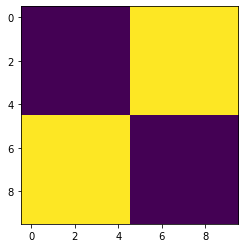

In [55]:
#print(metal_grid)
print(f"Size of the grid: {metal_grid.size}")
plt.imshow(metal_grid)

Size of the grid: 100


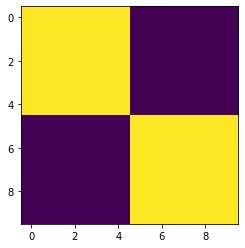

In [56]:
#print(hydrogen_grid)
print(f"Size of the grid: {hydrogen_grid.size}")
plt.imshow(hydrogen_grid)

Successful Hydrogen self-diffusion - No changes expected!


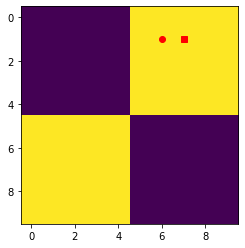

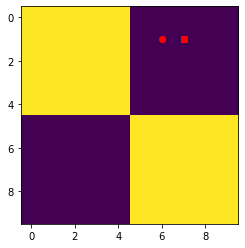

Successful Hydrogen self-diffusion - No changes expected!


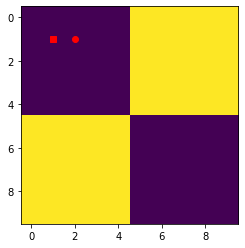

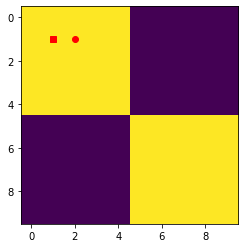

Successful Hydrogen self-diffusion - No changes expected!


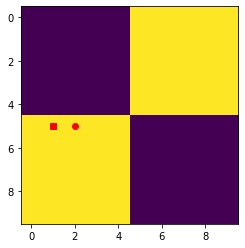

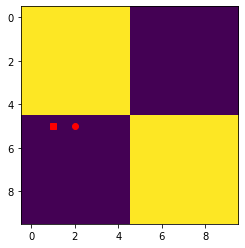

Successful Hydrogen self-diffusion - No changes expected!


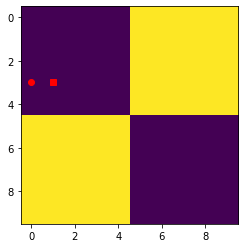

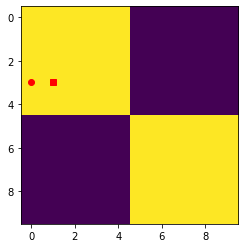

Successful Hydrogen self-diffusion - No changes expected!


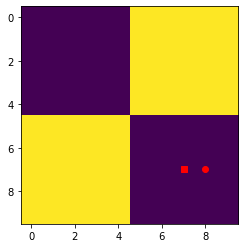

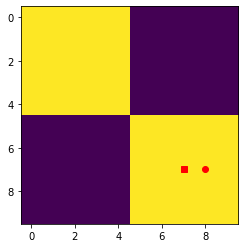

Successful Hydrogen self-diffusion - No changes expected!


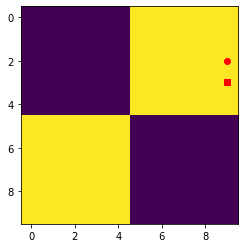

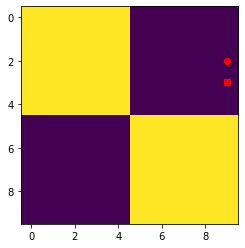

Successful Hydrogen self-diffusion - No changes expected!


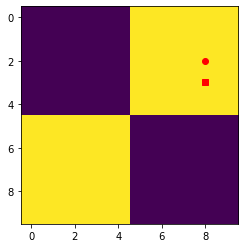

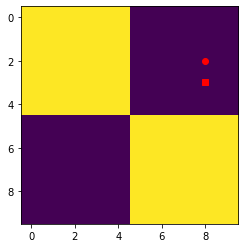

Successful Hydrogen self-diffusion - No changes expected!


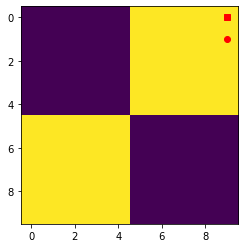

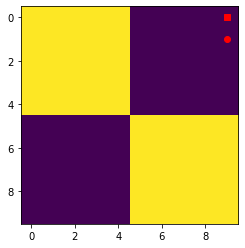

Successful Hydrogen self-diffusion - No changes expected!


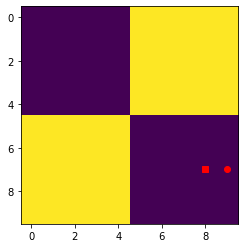

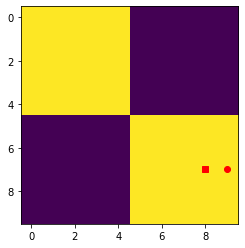

Trying to swap positions (7,9) with (7,0) - The change in energy is -2
Jump accepted!


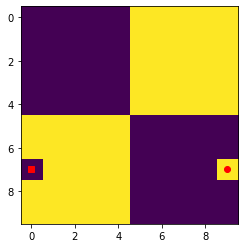

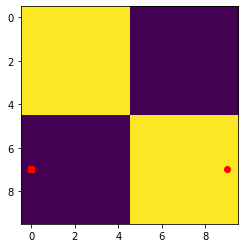

In [57]:
kT = 1
E_AA = 0
E_BB = 0
E_AB = -1
E_AH = -1
E_BH = 1

# Initialize counter for successful jumps
successful_jumps = 0
total_steps = 10  # Total number of Monte Carlo steps


for i in range(total_steps):
    # Save the state of the grid before attempting the Monte Carlo step
    previous_grid = metal_grid.copy()
    
    # Perform one Monte Carlo step
    _, x, y, nx, ny = metal_diffusion_step_with_hydrogen(metal_grid, hydrogen_grid, kT, E_AA=E_AA, E_BB=E_BB, E_AB=E_AB, E_AH=E_AH, E_BH=E_BH) 

    # Print the final grid
    plt.imshow(metal_grid)
    plt.plot(y, x, "o", color="red")
    plt.plot(ny, nx, "s", color="red")
    plt.show()
    plt.imshow(hydrogen_grid)
    plt.plot(y, x, "o", color="red")
    plt.plot(ny, nx, "s", color="red")
    plt.show()


---

### def calculate_hydrogen_metal_interaction_energy(x, y, hydrogen_grid, metal_grid, E_AH, E_BH):

Hydrogen atoms in the interstitial sites between metal atoms interact with the surrounding metals. Depending on whether the metal is type A or B, the interaction energy differs. This function calculates the sum of the interaction energies for the hydrogen atom at position (x, y).


        
---

In [58]:
# Function to calculate interaction energy of hydrogen atoms with surrounding metals, including periodic boundary conditions
def calculate_hydrogen_metal_interaction_energy(x, y, hydrogen_grid, metal_grid, E_AH, E_BH):
    """
    Function to calculate the interaction energy between a hydrogen atom and its surrounding metal atoms.
    This function assumes periodic boundary conditions, so if the hydrogen atom is near the edge of the grid,
    it still interacts with metal atoms on the opposite side.
    
    Parameters:
    x, y                : int, coordinates of the hydrogen atom on the hydrogen grid.
    hydrogen_grid       : 2D numpy array, grid representing the presence of hydrogen atoms in the interstitial sites.
    metal_grid          : 2D numpy array, grid representing metal atoms (A and B) in the system.
    E_AH                : float, interaction energy between metal A atoms and hydrogen.
    E_BH                : float, interaction energy between metal B atoms and hydrogen.
    
    Returns:
    energy              : float, total interaction energy between the hydrogen atom and its surrounding metal atoms.
    """
    energy = 0
    if hydrogen_grid[x, y] == 1:  # Check if there's a hydrogen atom at (x, y)
        # Get the surrounding metal atoms with periodic boundary conditions,
        # Similar but opposite to the metal-hydrogen interactions, as in reallity the hydrogen grid lies inbetween the metal grid
        metal_1 = metal_grid[x % grid_size, y % grid_size]
        metal_2 = metal_grid[x % grid_size, (y+1) % grid_size]
        metal_3 = metal_grid[(x+1) % grid_size, y % grid_size]
        metal_4 = metal_grid[(x+1) % grid_size, (y+1) % grid_size]
        
        # Calculate interaction energy between hydrogen and surrounding metal atoms
        # Similar to the code calculating the metal-hydrogen interactions,
        # but here we can assume that the hydrogen site is occupied, i.e., 1
        for metal in [metal_1, metal_2, metal_3, metal_4]:
            if metal == 0:  # Metal A
                energy += E_AH
            else:  # Metal B
                energy += E_BH
    return energy

#### Demonstration

In [59]:
# If you want to start a new simulation you can re-initialize the grid here
grid_size = 4
metal_grid = initialize_metal_grid(grid_size)
hydrogen_grid = initialize_hydrogen_grid(grid_size)

[[0 0 1 1]
 [0 0 1 1]
 [1 1 0 0]
 [1 1 0 0]]


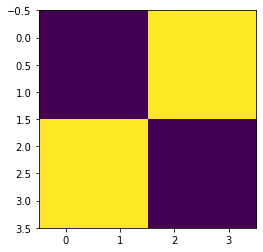

In [60]:
print(metal_grid)
plt.imshow(metal_grid)

[[1 1 0 0]
 [1 1 0 0]
 [0 0 1 1]
 [0 0 1 1]]


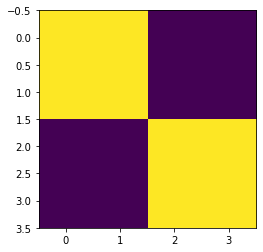

In [61]:
print(hydrogen_grid)
plt.imshow(hydrogen_grid)

In [62]:
x = 2
y = 0
E_AH = -1
E_BH = 0.5

calculate_hydrogen_metal_interaction_energy(x, y, hydrogen_grid, metal_grid, E_AH, E_BH)

0

---
### def hydrogen_diffusion_step(hydrogen_grid, metal_grid, kT, E_AH, E_BH):

#### Physical Interpretation:

Hydrogen Diffusion:

    This function models the diffusion of hydrogen atoms in the interstitial sites of a metal lattice. Hydrogen atoms can move to neighboring empty sites, driven by thermal energy and interaction energies between hydrogen and surrounding metal atoms.

Metropolis Criterion:

    Similar to the metal diffusion process, the Metropolis criterion governs whether a hydrogen atom moves to a neighboring site based on the energy difference. This criterion ensures that while the system tends towards lower energy, it occasionally accepts moves that increase energy, allowing for thermal fluctuations.

Periodic Boundary Conditions:

    The periodic boundary conditions allow hydrogen atoms near the edges of the grid to interact and move across the grid boundaries, simulating a continuous, infinite lattice.
    
---

In [63]:
# Function to perform a metal diffusion step considering both metal-hydrogen interactions with periodic boundary conditions
def hydrogen_diffusion_step(hydrogen_grid, metal_grid, kT, E_AH, E_BH, hydrogen_positions):
    """
    Function to perform a hydrogen diffusion step in the system, considering interaction with neighboring metal atoms
    and periodic boundary conditions. A hydrogen atom is randomly selected and swapped with a neighboring empty site,
    and the Metropolis criterion is applied to decide whether the swap is accepted based on the energy change.
    
    Parameters:
    hydrogen_grid       : 2D numpy array, grid representing the presence of hydrogen atoms in the interstitial sites.
    metal_grid          : 2D numpy array, grid representing metal atoms (A and B) in the system.
    kT                  : float, thermal energy factor (k * T), controlling the acceptance of energetically unfavorable moves.
    E_AH                : float, interaction energy between metal A atoms and hydrogen.
    E_BH                : float, interaction energy between metal B atoms and hydrogen.
    
    Returns:
    accept              : bool, returns True if a successful diffusion attempt has been performed.
    """
    # Select a random hydrogen atom
    idx = np.random.randint(0, len(hydrogen_positions))
    x, y = hydrogen_positions[idx]
    
    # Select a random neighbor (up, down, left, right)
    direction = np.random.randint(0, 4)
    if direction == 0: nx, ny = (x - 1) % grid_size, y  # Up
    elif direction == 1: nx, ny = (x + 1) % grid_size, y  # Down
    elif direction == 2: nx, ny = x, (y - 1) % grid_size  # Left
    else: nx, ny = x, (y + 1) % grid_size  # Right

    # Ensure the chosen site is empty (avoid unnecessary swaps)
    if hydrogen_grid[nx, ny] == 1:
        print("Successful hydrogen self-diffusion - No changes expected!")
        return True, x, y, nx, ny  # No swap possible, return early, jump would be successful and therefore return True

    # Calculate the initial energy (before the swap)
    initial_energy = calculate_hydrogen_metal_interaction_energy(x, y, hydrogen_grid, metal_grid, E_AH, E_BH)

    # Swap hydrogen atoms
    hydrogen_grid[x, y], hydrogen_grid[nx, ny] = hydrogen_grid[nx, ny], hydrogen_grid[x, y]

    # Calculate the final energy (after the swap)
    final_energy = calculate_hydrogen_metal_interaction_energy(nx, ny, hydrogen_grid, metal_grid, E_AH, E_BH)

    # Calculate the energy change
    delta_E = final_energy - initial_energy

    # ONLY FOR TUTORIAL
    print(f"Trying to swap positions ({x},{y}) with ({nx},{ny}) - The change in energy is {delta_E}")
    
    accept = True
    # Apply the Metropolis criterion
    if delta_E > 0 and np.exp(-delta_E / kT) < np.random.rand():
        accept = False
        # Revert the hydrogen swap if the move is rejected
        hydrogen_grid[x, y], hydrogen_grid[nx, ny] = hydrogen_grid[nx, ny], hydrogen_grid[x, y]
        
    # Update Hydrogen Position Array
    if accept:
        hydrogen_positions[idx, 0] = nx  # Update x-coordinate
        hydrogen_positions[idx, 1] = ny  # Update y-coordinate
        
    # ONLY FOR TUTORIAL
    if accept == True:
        print("Jump accepted!")
    else:
        print("Jump rejected!")

    return accept, x, y, nx, ny


#### Demonstration

In [64]:
# If you want to start a new simulation you can re-initialize the grid here
grid_size = 10
metal_grid = initialize_metal_grid(grid_size)
hydrogen_grid = initialize_hydrogen_grid(grid_size)

[[0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]]


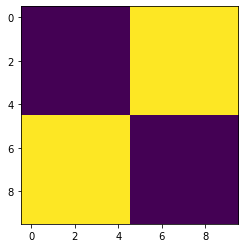

In [65]:
print(metal_grid)
plt.imshow(metal_grid)

[[1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]]


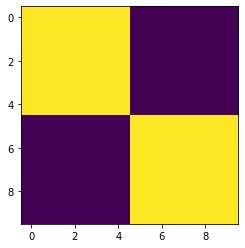

In [66]:
print(hydrogen_grid)
plt.imshow(hydrogen_grid)

Trying to swap positions (9,5) with (0,5) - The change in energy is -4
Jump accepted!
[[1 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1]]


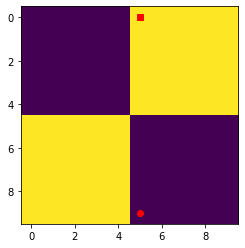

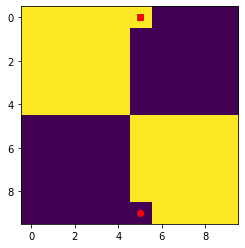

Successful hydrogen self-diffusion - No changes expected!
[[1 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1]]


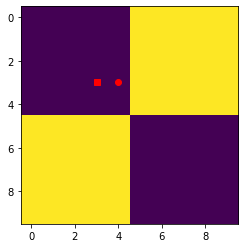

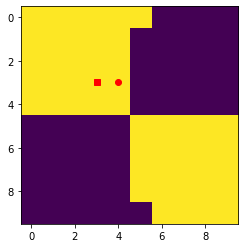

Successful hydrogen self-diffusion - No changes expected!
[[1 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1]]


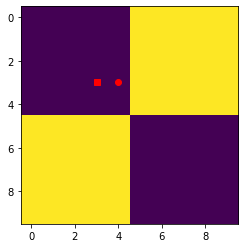

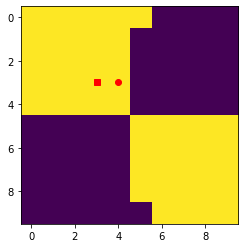

Successful hydrogen self-diffusion - No changes expected!
[[1 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1]]


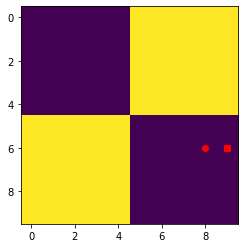

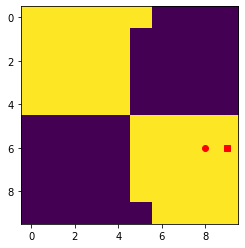

Trying to swap positions (9,9) with (0,9) - The change in energy is 0
Jump accepted!
[[1 1 1 1 1 1 0 0 0 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 0]]


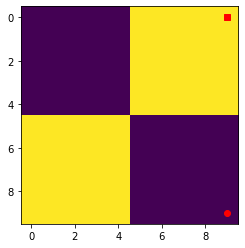

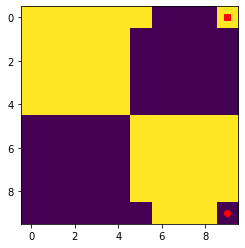

Trying to swap positions (7,9) with (7,0) - The change in energy is -4
Jump accepted!
[[1 1 1 1 1 1 0 0 0 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [1 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 0]]


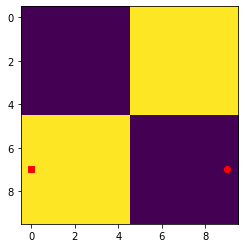

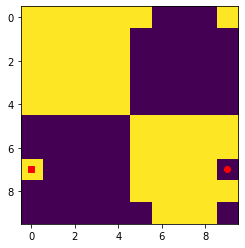

Trying to swap positions (0,2) with (9,2) - The change in energy is -4
Jump accepted!
[[1 1 0 1 1 1 0 0 0 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [1 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 1 0 0 0 1 1 1 0]]


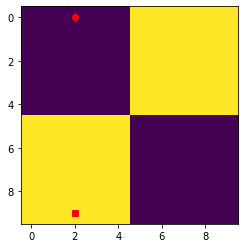

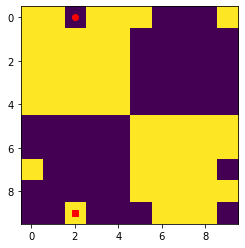

Successful hydrogen self-diffusion - No changes expected!
[[1 1 0 1 1 1 0 0 0 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [1 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 1 0 0 0 1 1 1 0]]


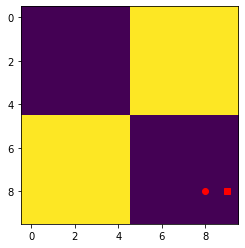

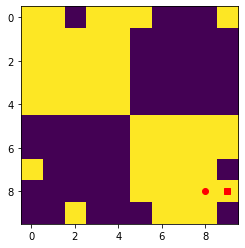

Successful hydrogen self-diffusion - No changes expected!
[[1 1 0 1 1 1 0 0 0 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [1 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 1 0 0 0 1 1 1 0]]


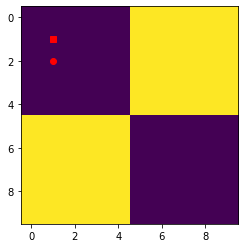

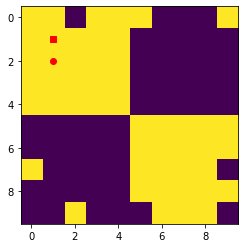

Successful hydrogen self-diffusion - No changes expected!
[[1 1 0 1 1 1 0 0 0 1]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [1 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 1 0 0 0 1 1 1 0]]


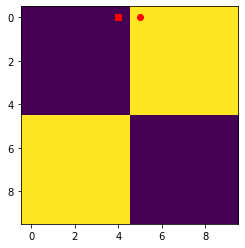

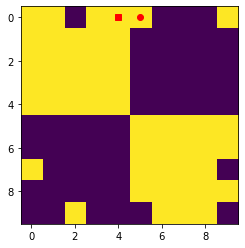

In [67]:
kT = 1
E_AH = +1
E_BH = -1

# Initialize counter for successful jumps
successful_jumps = 0
total_steps = 10  # Total number of Monte Carlo steps

hydrogen_positions = np.argwhere(hydrogen_grid == 1)

for i in range(total_steps):

    # Perform one Monte Carlo step
    _, x, y, nx, ny = hydrogen_diffusion_step(hydrogen_grid, metal_grid, kT, E_AH, E_BH, hydrogen_positions) 

    # Print the final grid
    print(hydrogen_grid)
    plt.imshow(metal_grid)
    plt.plot(y, x, "o", color="red")
    plt.plot(ny, nx, "s", color="red")
    plt.show()
    plt.imshow(hydrogen_grid)
    plt.plot(y, x, "o", color="red")
    plt.plot(ny, nx, "s", color="red")
    plt.show()



---

### def calculate_total_metal_hydrogen_interaction_energy(metal_grid, hydrogen_grid, E_AH, E_BH):

#### Physical Interpretation:

Metal-Hydrogen Interactions:

    Each metal atom also interacts with the surrounding hydrogen atoms in the interstitial sites. The interaction energy depends on the metal type (A or B) and the corresponding interaction energy (E_AH or E_BH). These interactions influence the overall configuration of the system, as hydrogen atoms may prefer to remain near certain metal atoms, driving diffusion and alloying processes.
        
---

In [68]:
# Function that sums up all the interaction energies between hydrogen and metals
def calculate_total_metal_hydrogen_interaction_energy(metal_grid, hydrogen_grid, E_AH, E_BH):
    """
    Vectorized calculation of the total metal-hydrogen interaction energy in the grid.

    Parameters:
    - metal_grid       : np.array, 2D array representing metal atom types (0 for A, 1 for B).
    - hydrogen_grid    : np.array, 2D array representing hydrogen atom presence (1 for hydrogen, 0 for empty).
    - E_AH             : float, interaction energy between metal A atoms and hydrogen.
    - E_BH             : float, interaction energy between metal B atoms and hydrogen.

    Returns:
    - total_energy     : float, total interaction energy between all hydrogen atoms and their surrounding metals.
    """
    # Shift the metal grid to simulate the periodic neighbor interactions
    # Hydrogen interacts with the 4 surrounding metal atoms (periodic boundary conditions are applied):
    metal_neighbor_1 = metal_grid  # top left intersitial neighbor
    metal_neighbor_2 = np.roll(metal_grid, shift= -1, axis=1)  # top right intersitial neighbor
    metal_neighbor_3 = np.roll(metal_grid, shift= -1, axis=0)  # lower left intersitial neighbor
    metal_neighbor_4 = np.roll(np.roll(metal_grid, shift= -1, axis=0), shift= -1, axis=1)  # lower right intersitial neighbor

    interaction_AH = 0
    interaction_BH = 0
    for metal_grid in [metal_neighbor_1, metal_neighbor_2, metal_neighbor_3, metal_neighbor_4]:
        # Interaction for A atoms (A = 0), only where hydrogen is present (hydrogen_grid == 1)
        interaction_AH += (metal_grid == 0) * (hydrogen_grid == 1) * E_AH
        # Interaction for B atoms (B = 1), only where hydrogen is present (hydrogen_grid == 1)
        interaction_BH += (metal_grid == 1) * (hydrogen_grid == 1) * E_BH
    
    total_energy = np.sum(interaction_AH) + np.sum(interaction_BH)

    return total_energy


In [69]:
sns.color_palette("deep", 5)

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254)]

#### Demonstration

In [70]:
# If you want to start a new simulation you can re-initialize the grid here
grid_size     = 4
metal_grid    = initialize_metal_grid(grid_size)
hydrogen_grid = initialize_hydrogen_grid(grid_size)

In [71]:
print(metal_grid)

[[0 0 1 1]
 [0 0 1 1]
 [1 1 0 0]
 [1 1 0 0]]


In [72]:
print(hydrogen_grid)

[[1 1 0 0]
 [1 1 0 0]
 [0 0 1 1]
 [0 0 1 1]]


In [73]:
E_AH = -1
E_BH = +0.5

calculate_total_metal_hydrogen_interaction_energy(metal_grid, hydrogen_grid, E_AH, E_BH)

-14.0

In [74]:
#hydrogen_grid = np.ones((grid_size, grid_size))
#hydrogen_grid

#### Demonstration+ 

In [75]:
# Similar to the enthalpy input values for the metal-metal interactions
# the enthalpy of dissolution / hydride formation is only completely released if the hydrogen is surounded by 4 metal atoms (of the same kind).
# Therefore the interaction energy is only 1/4 of this enthalpy, because in this 2D case every H can be surrounded by 4 metal atoms.
E_AH =  1 / 4
E_BH = - 1 / 4

E_tot = calculate_total_metal_hydrogen_interaction_energy(metal_grid, hydrogen_grid, E_AH, E_BH)

In [76]:
# Dividing by the amount of H results again in the original enthalpie input.
dH_diss = E_tot / hydrogen_grid.sum()
dH_diss

0.25